In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# Loading Common Questions and Hard Questions Evaluation Data
phi_eval_c = pd.DataFrame(json.loads(open("./data/phi2_eval_df_c.json", "r").read()))
phi_eval_h = pd.DataFrame(json.loads(open("./data/phi2_eval_hard.json", "r").read()))
def_eval_c = pd.DataFrame(json.loads(open("./data/sqlc_eval_df_c.json", "r").read()))
def_eval_h = pd.DataFrame(json.loads(open("./data/sqlc_eval_hard.json", "r").read()))

# Loading Training Logs for Fine-tuning Phi-2
training_logs = pd.read_csv("./data/training_logs.csv")

phi_eval_c.shape, phi_eval_h.shape, def_eval_c.shape, def_eval_h.shape, training_logs.shape

((1258, 9), (33, 9), (1258, 9), (33, 9), (31, 3))

In [3]:
phi_eval = pd.concat([phi_eval_c, phi_eval_h])
def_eval = pd.concat([def_eval_c, def_eval_h])

phi_eval.shape, def_eval.shape

((1291, 9), (1291, 9))

In [4]:
phi_eval.columns

Index(['prompt', 'pred', 'actu', 'inf_time', 'temperature', 'difficulty',
       'token_in', 'token_out', 'tokens_per_sec'],
      dtype='object')

In [5]:
phi_eval['tokens_per_sec'] = (phi_eval['token_in'] + phi_eval['token_out'])/phi_eval['inf_time']
def_eval['tokens_per_sec'] = (def_eval['token_in'] + def_eval['token_out'])/def_eval['inf_time']

phi_eval['all_tokens'] = phi_eval['token_in'] + phi_eval['token_out']
def_eval['all_tokens'] = def_eval['token_in'] + def_eval['token_out']

phi_eval['question'] = phi_eval['prompt'].apply(lambda x :x.split("`")[1])
def_eval['question'] = def_eval['prompt'].apply(lambda x :x.split("`")[1])

phi_eval['context'] = phi_eval['prompt'].apply(lambda x :x.split("schema:\n")[-1].split("\n\n")[0])
def_eval['context'] = def_eval['prompt'].apply(lambda x :x.split("schema:\n")[-1].split("\n\n")[0])

## Evaluation Plots

### Difficulty vs Inference Time

In [6]:
phi_eval.groupby('difficulty')['inf_time'].mean().reset_index().sort_values('inf_time')

,difficulty,inf_time
0,easy,16.261769
2,medium,20.397285
1,hard,38.548714


In [7]:
def_eval.groupby('difficulty')['inf_time'].mean().reset_index().sort_values('inf_time')

,difficulty,inf_time
0,easy,30.854192
2,medium,38.260510
1,hard,57.408160


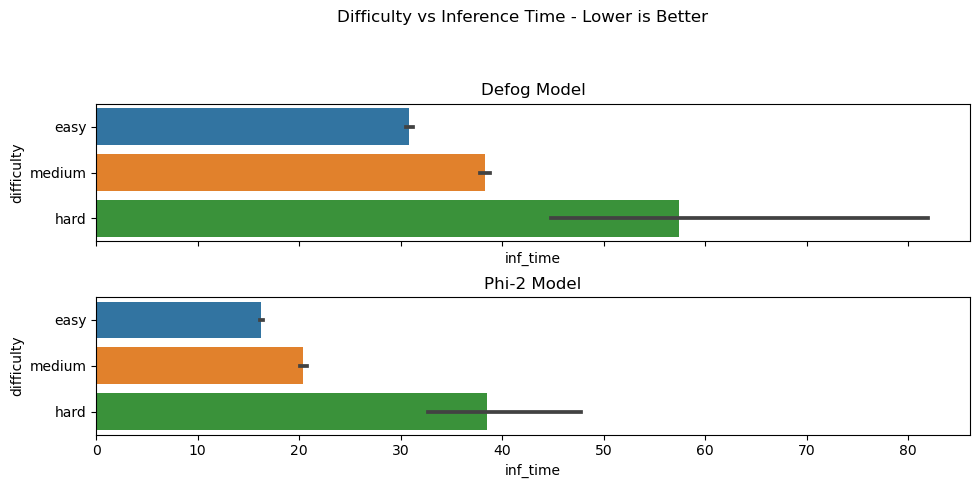

In [8]:
# diffculty vs inf_time - bar
figure, axes = plt.subplots(2, 1, sharex=True,
                            figsize=(10, 5))
figure.suptitle('Difficulty vs Inference Time - Lower is Better')
figure.tight_layout(pad=3)

axes[0].set_title('Defog Model')
sns.barplot(def_eval, y="difficulty", x="inf_time", ax=axes[0])

axes[1].set_title('Phi-2 Model')
sns.barplot(phi_eval, y="difficulty", x="inf_time", ax=axes[1])

plt.savefig('./out_images/'+'Difficulty vs Inference Time.png', bbox_inches='tight')

### Number of Tokens vs Inference Time

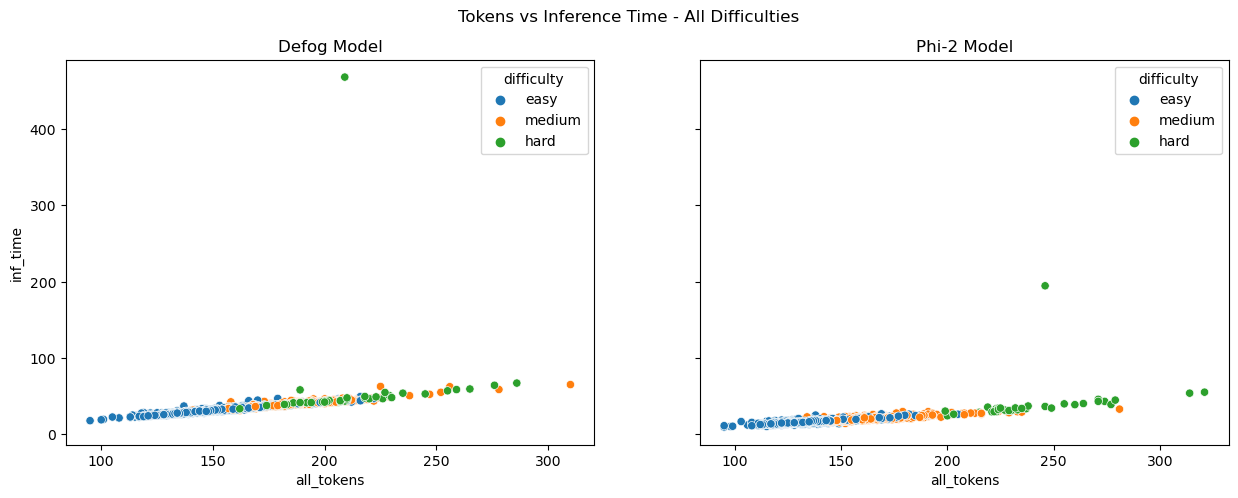

In [9]:
# tokens vs inf_time
figure, axes = plt.subplots(1, 2, sharey=True,
                            figsize=(15, 5))
figure.suptitle('Tokens vs Inference Time - All Difficulties')

axes[0].set_title('Defog Model')
sns.scatterplot(def_eval, x="all_tokens", y="inf_time", hue="difficulty", ax=axes[0])

axes[1].set_title('Phi-2 Model')
sns.scatterplot(phi_eval, x="all_tokens", y="inf_time", hue="difficulty", ax=axes[1])
plt.savefig('./out_images/'+'Tokens vs Inference Time', bbox_inches='tight')

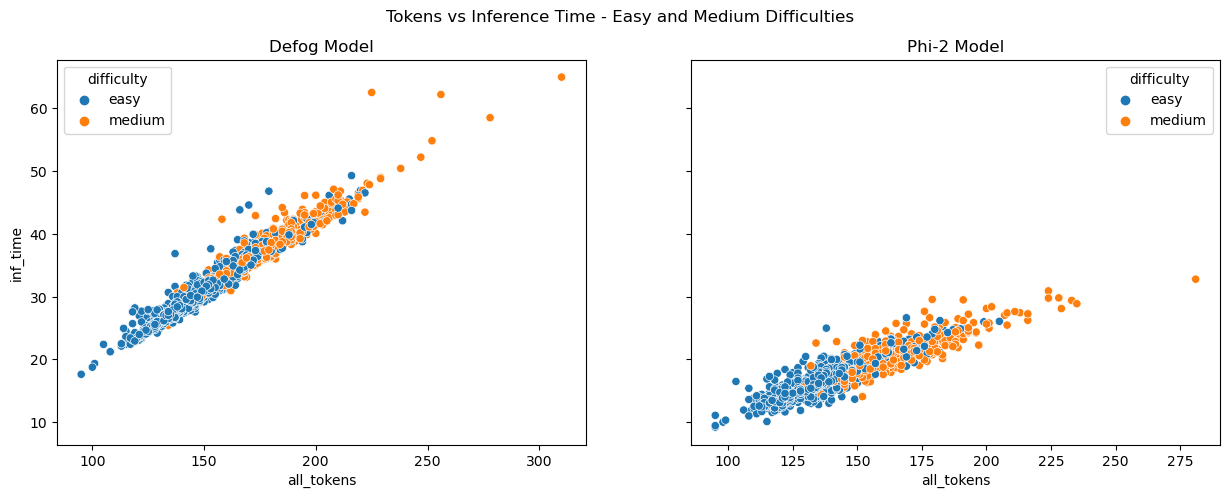

In [10]:
# tokens vs inf_time
figure, axes = plt.subplots(1, 2, sharey=True,
                            figsize=(15, 5))
figure.suptitle('Tokens vs Inference Time - Easy and Medium Difficulties')

axes[0].set_title('Defog Model')
sns.scatterplot(def_eval[def_eval['difficulty'].isin(['easy', 'medium'])], x="all_tokens", y="inf_time", hue="difficulty", ax=axes[0])

axes[1].set_title('Phi-2 Model')
sns.scatterplot(phi_eval[phi_eval['difficulty'].isin(['easy', 'medium'])], x="all_tokens", y="inf_time", hue="difficulty", ax=axes[1])
plt.savefig('./out_images/'+'Tokens vs Inference Time - Easy and Medium Difficulties', bbox_inches='tight')

### Number of Tokens per Sec vs Difficulty

In [11]:
phi_eval.groupby('difficulty')['tokens_per_sec'].mean().reset_index().sort_values('tokens_per_sec')

,difficulty,tokens_per_sec
1,hard,6.829720
2,medium,8.058363
0,easy,8.390820


In [12]:
def_eval.groupby('difficulty')['tokens_per_sec'].mean().reset_index().sort_values('tokens_per_sec')

,difficulty,tokens_per_sec
1,hard,4.474975
2,medium,4.726500
0,easy,4.854409


In [45]:
round((8.390820-4.854409)/8.390820,5)*100, round((8.058363-4.726500)/8.058363,5)*100, round((6.829720-4.474975)/6.829720,5)*100

(42.146, 41.347, 34.477999999999994)

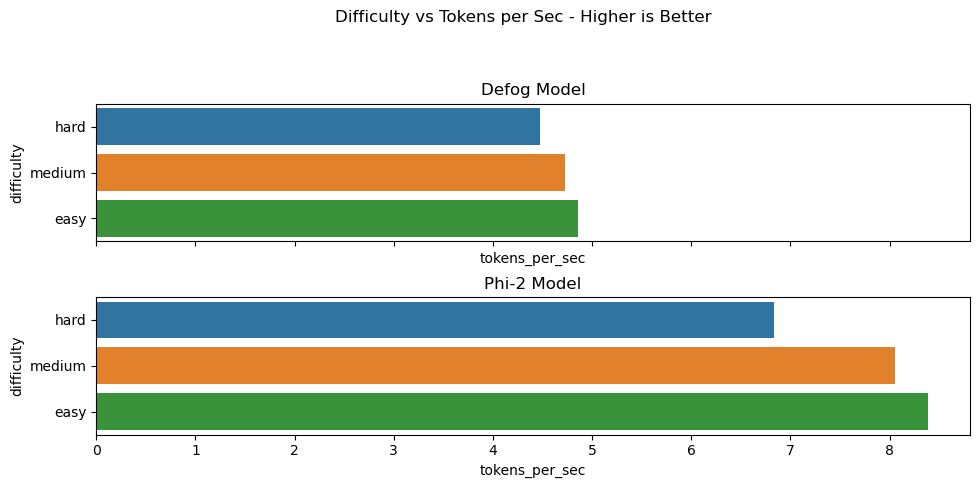

In [13]:
# diffculty vs tokens_per_inf_time - bar
figure, axes = plt.subplots(2, 1, sharex=True,
                            figsize=(10, 5))
figure.suptitle('Difficulty vs Tokens per Sec - Higher is Better')
figure.tight_layout(pad=3)

axes[0].set_title('Defog Model')
sns.barplot(def_eval.groupby('difficulty')['tokens_per_sec'].mean().reset_index().sort_values('tokens_per_sec'),y="difficulty", x="tokens_per_sec", ax=axes[0])

axes[1].set_title('Phi-2 Model')
sns.barplot(phi_eval.groupby('difficulty')['tokens_per_sec'].mean().reset_index().sort_values('tokens_per_sec'),y="difficulty", x="tokens_per_sec", ax=axes[1])
plt.savefig('./out_images/'+'Difficulty vs Tokens per Sec', bbox_inches='tight')

### Tokens Generated vs Difficulty

In [47]:
phi_eval.groupby('difficulty')['token_out'].mean().reset_index().sort_values('token_out')

,difficulty,token_out
0,easy,25.839450
2,medium,33.673684
1,hard,81.692308


In [48]:
def_eval.groupby('difficulty')['token_out'].mean().reset_index().sort_values('token_out')

,difficulty,token_out
0,easy,34.969037
2,medium,46.142105
1,hard,65.538462


In [49]:
round((34.969037-25.839450)/34.969037,5)*100, round((46.142105-33.673684)/46.142105,5)*100, round((65.538462-81.692308)/81.692308,5)*100

(26.107999999999997, 27.022000000000002, -19.774)

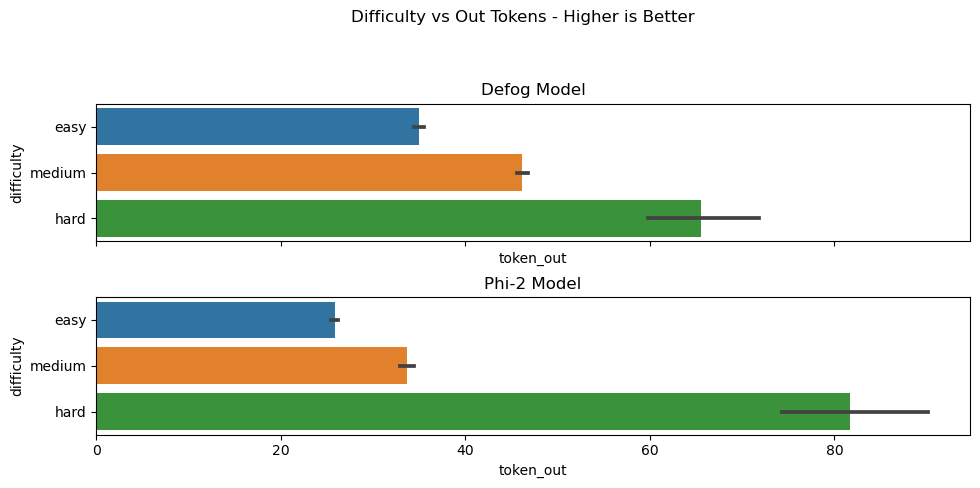

In [14]:
# diffculty vs out tokens - bar
figure, axes = plt.subplots(2, 1, sharex=True,
                            figsize=(10, 5))
figure.suptitle('Difficulty vs Out Tokens - Higher is Better')
figure.tight_layout(pad=3)

axes[0].set_title('Defog Model')
sns.barplot(def_eval, y="difficulty", x="token_out", ax=axes[0])

axes[1].set_title('Phi-2 Model')
sns.barplot(phi_eval, y="difficulty", x="token_out", ax=axes[1])
plt.savefig('./out_images/'+'Difficulty vs Out Tokens', bbox_inches='tight')

### Execution Success 

In [69]:
import sqlite3

## Create DB schema based on context and run the query to check for execution.
def execution_test(row):
    conn = sqlite3.connect(':memory:') 
    script = row['context']
    success = True
    try:
        conn.executescript(script)
        sql_query = pd.read_sql_query(row['pred'], conn)
    except:
        success = False
    return success

phi_eval['exec_success'] = phi_eval.apply(lambda x: execution_test(x), axis=1).map({True: '1', False: '0'})
def_eval['exec_success'] = def_eval.apply(lambda x: execution_test(x), axis=1).map({True: '1', False: '0'})
phi_eval['exec_success_int'] = phi_eval.apply(lambda x: execution_test(x), axis=1).map({True: 1, False: 0})
def_eval['exec_success_int'] = def_eval.apply(lambda x: execution_test(x), axis=1).map({True: 1, False: 0})

In [75]:
phi_eval.groupby('difficulty')['exec_success_int'].mean().reset_index().sort_values('exec_success_int'), def_eval.groupby('difficulty')['exec_success_int'].mean().reset_index().sort_values('exec_success_int')

(  difficulty  exec_success_int
 1       hard          0.487179
 2     medium          0.918421
 0       easy          0.985092,
   difficulty  exec_success_int
 2     medium          0.513158
 1       hard          0.564103
 0       easy          0.620413)

In [77]:
round((22-19)/22,5)*100, round((349-195)/349,5)*100, round((859-541)/859,5)*100, (98+91+48)/300, (62+56+51)/300

(13.636000000000001, 44.126, 37.019999999999996, 0.79, 0.5633333333333334)

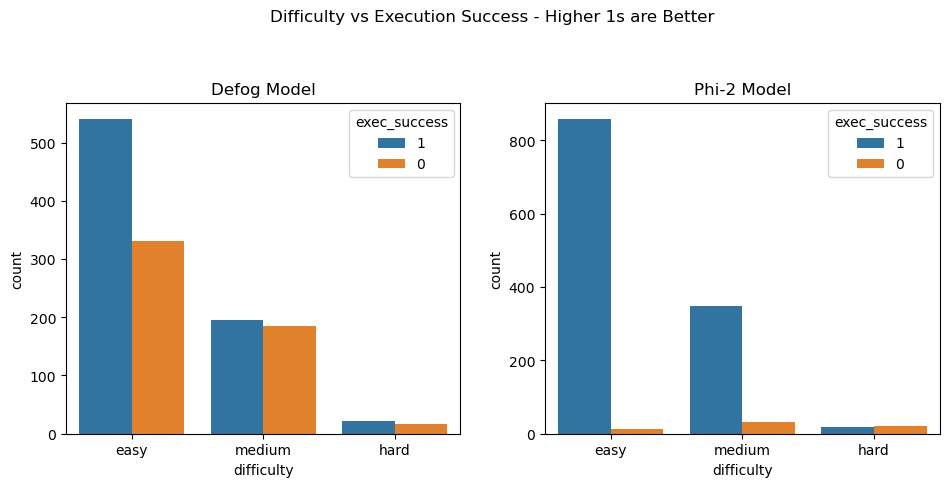

In [25]:
# diffculty vs inf_time - bar
figure, axes = plt.subplots(1, 2, sharex=True,
                            figsize=(10, 5))
figure.suptitle('Difficulty vs Execution Success - Higher 1s are Better')
figure.tight_layout(pad=3)

axes[0].set_title('Defog Model')
sns.countplot(def_eval, x="difficulty", ax=axes[0], hue="exec_success", hue_order="10")

axes[1].set_title('Phi-2 Model')
sns.countplot(phi_eval, x="difficulty", ax=axes[1], hue="exec_success")

plt.savefig('./out_images/'+'Difficulty vs Execution Success', bbox_inches='tight')

### Exact Matches

In [17]:
## Check perfect matches based on the actual value
phi_eval['exact_match'] = phi_eval['pred'].str.lower().str.strip() == phi_eval['actu'].str.lower().str.strip()
def_eval['exact_match'] = def_eval['pred'].str.lower().str.strip() == def_eval['actu'].str.lower().str.strip()

phi_eval['exact_match'] = phi_eval['exact_match'].map({True: '1', False: '0'})
def_eval['exact_match'] = def_eval['exact_match'].map({True: '1', False: '0'})

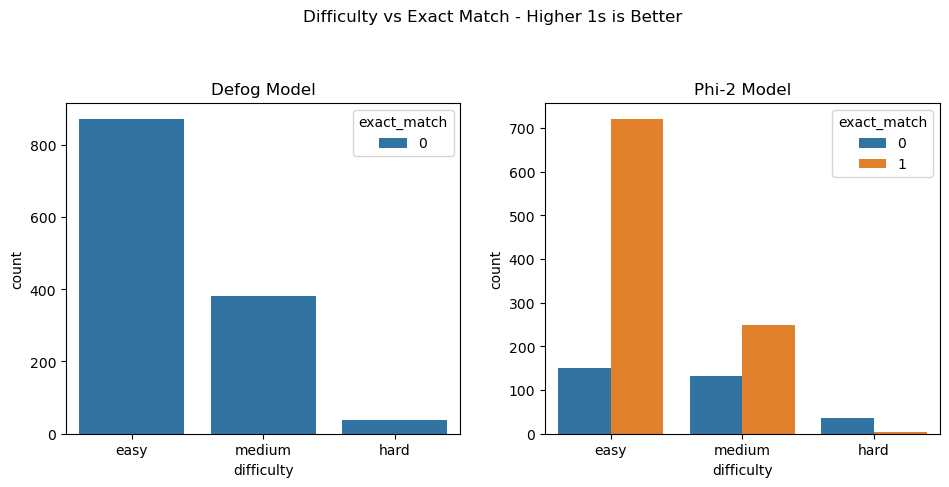

In [18]:
# diffculty vs inf_time - bar
figure, axes = plt.subplots(1, 2, sharex=True,figsize=(10, 5))
figure.suptitle('Difficulty vs Exact Match - Higher 1s is Better')
figure.tight_layout(pad=3)

axes[0].set_title('Defog Model')
sns.countplot(def_eval, x="difficulty", ax=axes[0], hue="exact_match")

axes[1].set_title('Phi-2 Model')
sns.countplot(phi_eval, x="difficulty", ax=axes[1], hue="exact_match")

plt.savefig('./out_images/'+'Difficulty vs Exact Match', bbox_inches='tight')

### Training Logs

In [19]:
training_logs['train_accuracy'] = 1 - training_logs['Training Loss']
training_logs['val_accuracy'] = 1 - training_logs['Validation Loss']

In [20]:
training_logs.columns = ['step', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']

C:\Users\pavan\anaconda3\envs\phi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pavan\anaconda3\envs\phi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pavan\anaconda3\envs\phi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pavan\anaconda3\envs\phi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

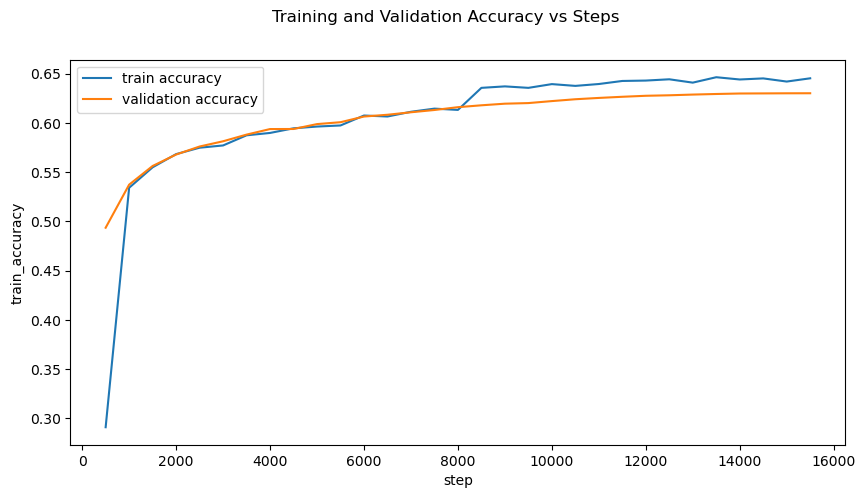

In [21]:
# training_logs
figure, axes = plt.subplots(1, 1, sharex=True,figsize=(10, 5))
figure.suptitle('Training and Validation Accuracy vs Steps')
sns.lineplot(data=training_logs, y="train_accuracy", x="step", label="train accuracy")
sns.lineplot(data=training_logs, y="val_accuracy", x="step", label="validation accuracy")

plt.savefig('./out_images/'+'Training and Validation Accuracy vs Steps', bbox_inches='tight')

C:\Users\pavan\anaconda3\envs\phi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pavan\anaconda3\envs\phi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pavan\anaconda3\envs\phi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pavan\anaconda3\envs\phi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

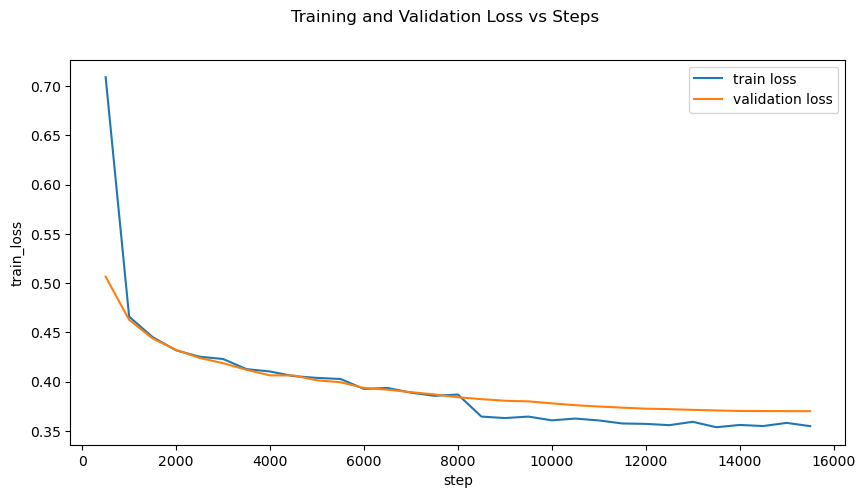

In [22]:
# training_logs
figure, axes = plt.subplots(1, 1, sharex=True,figsize=(10, 5))
figure.suptitle('Training and Validation Loss vs Steps')
sns.lineplot(data=training_logs, y="train_loss", x="step", label="train loss")
sns.lineplot(data=training_logs, y="val_loss", x="step", label="validation loss")

plt.savefig('./out_images/'+'Training and Validation Loss vs Steps', bbox_inches='tight')

<Axes: xlabel='size', ylabel='split'>

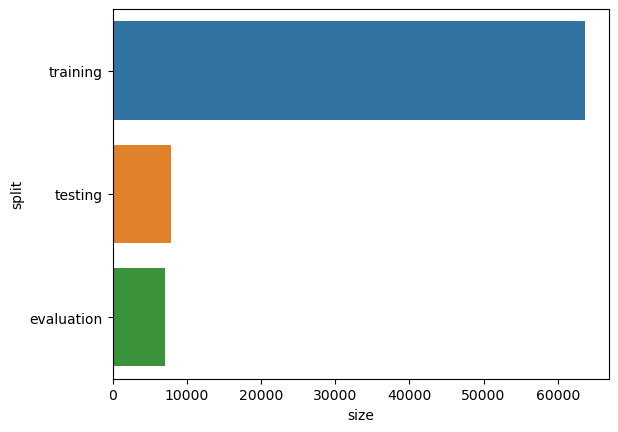

In [23]:
shapes = pd.DataFrame({"split": ["training", "testing", "evaluation"], "size": [63647, 7858, 7072]}, index=[1, 2, 3])
sns.barplot(shapes, y="split", x="size")

<Axes: xlabel='split', ylabel='size'>

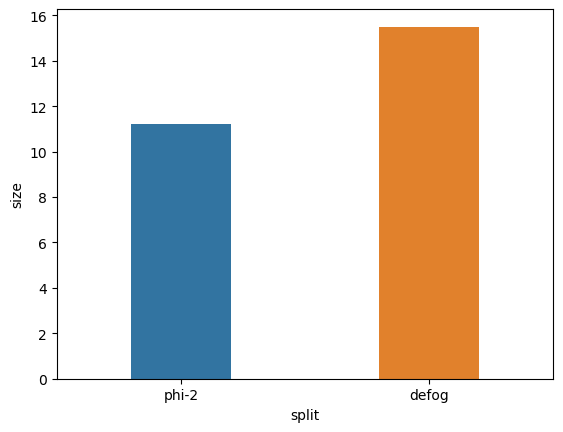

In [35]:
usage = pd.DataFrame({"split": ["phi-2", "defog"], "size": [11.2, 15.5]}, index=[1, 2])
sns.barplot(usage, x="split", y="size",width=0.4)